In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import gc

from sklearn.decomposition import PCA

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_G, weights_init_G
from src.icnn import FakeResNet64_D, FakeUNet64_H
from src.tools import train_identity_map, unfreeze, load_resnet_G, read_image_folder, freeze, get_generated_inception_stats
from src.plotters import plot_W2, plot_generated_images, plot_generated_emb
from src.fid_score import calculate_frechet_distance
from copy import deepcopy

from src.tools import CompositeGenerator

import json

from tqdm import tqdm
from IPython.display import clear_output

import wandb
from src.tools import fig2data, fig2img # for wandb

## Config

In [2]:
REVERSED = False
GPU_DEVICE = 2

D_ITERS = 10
INNER_ITERS = 15
BATCH_SIZE = 64 
PLOT_INTERVAL = 100
FID_INTERVAL = 1000
MAX_ITER=300000

## Hardcoded stuff

In [3]:
DIM = 64 * 64 * 3
METHOD = 'MM' if not REVERSED else 'MM:R'

OUTPUT_PATH = '../logs/CelebA_generation/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000000); np.random.seed(0x000000)

## Prepare Samplers (Z, Y) and Initialize PCA for visualization purposes

In [4]:
Z_sampler = distributions.StandardNormalSampler(dim=128)

In [5]:
DATASET_PATH = '../../data/img_align_celeba64/all/'

images = read_image_folder(DATASET_PATH, n_jobs=40, verbose=True)

dataset_uint8 = np.array([
    np.array(im, dtype=np.uint16) for im in images
]).astype(np.uint8).transpose(0, 3, 1 ,2)

del(images)
gc.collect()

0

In [6]:
Y_sampler = distributions.NormalNoiseTransformer(std=0.01).fit(
    distributions.TensorDatasetSampler(
        dataset_uint8.reshape(-1, 64*64*3),
        transform=lambda x: 2 * (x / 255.) - 1,
        storage='cpu',
        storage_dtype=torch.uint8,
        device='cuda'
    )
)
del dataset_uint8
gc.collect()

../src/distributions.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float32, requires_grad=False


20

In [7]:
print('Fitting PCA for visualization furing training.')
pca = PCA(n_components=6).fit(Y_sampler.sample(2**14).cpu().detach().numpy())
torch.cuda.empty_cache(); gc.collect()

Fitting PCA for visualization furing training.


20

In [8]:
#Loading CelebA Inception Stats for FID computation
with open('../models/celeba_inception_stats.json', 'r') as f:
    stats = json.load(f)
    mu_data = stats['mu']
    sigma_data = stats['sigma']
    del stats
    gc.collect()

# Initialize models

### Potentials setup

In [9]:
D = FakeResNet64_D().cuda()
D_conj = FakeUNet64_H(base_factor=48).cuda()

pretrain_sampler = distributions.CubeUniformSampler(DIM, centered=True)
print(
    'Pretraining identity potential. Final MSE:',
    train_identity_map(D, pretrain_sampler, BATCH_SIZE, max_iter=1000, tol=1e-3, blow=4, convex=False, verbose=True)
)
print(
    'Pretraining identity potential. Final MSE:',
    train_identity_map(D_conj, pretrain_sampler, BATCH_SIZE, max_iter=1000, tol=3e-4, blow=4, convex=False, verbose=True)
)

del pretrain_sampler

Training the potentials to satisfy push(x)=x



Pretraining identity potential. Final MSE: 3.012219987330589e-11
Training the potentials to satisfy push(x)=x



Pretraining identity potential. Final MSE: 0.002242602175101638


### Generator Network

In [10]:
G = ResNet_G(128, 64).cuda()
G.apply(weights_init_G)
print("G network initialized!")

G network initialized!


### Plots Test

../src/distributions.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float32, requires_grad=False
../src/distributions.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float32, requires_grad=False


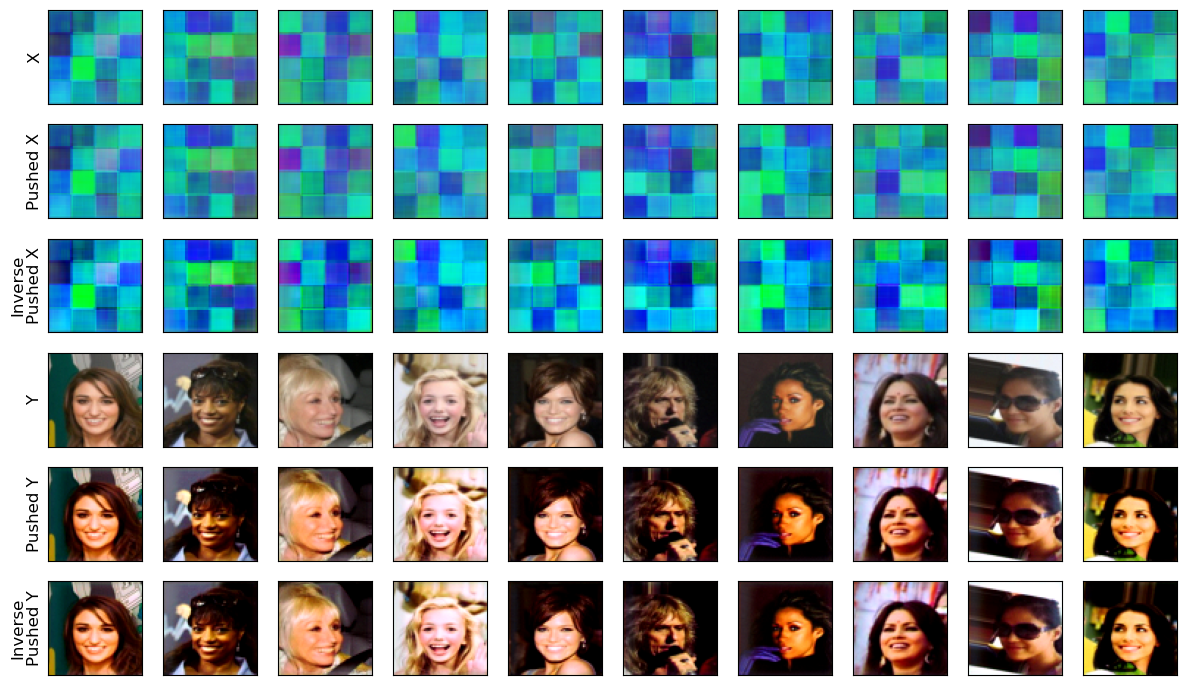

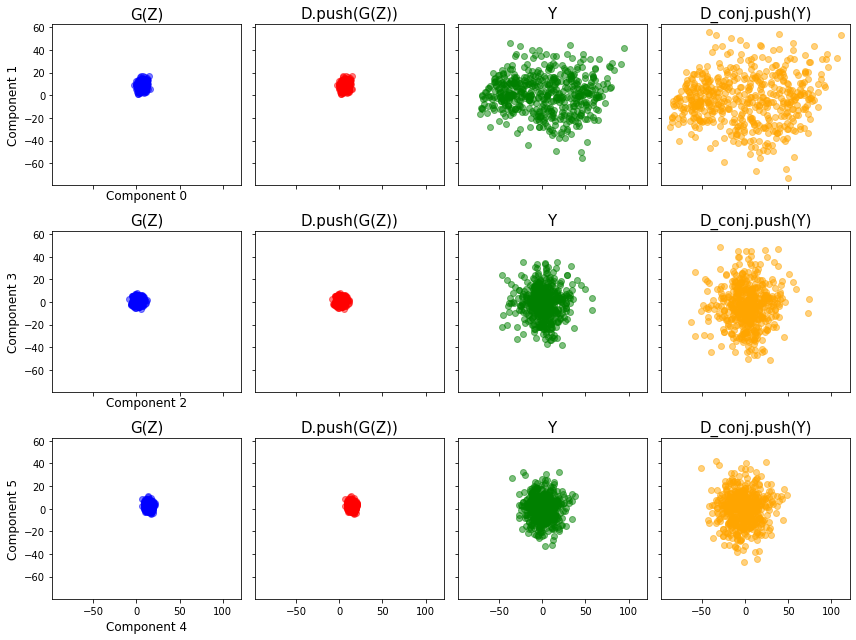

In [11]:
fig, axes = plot_generated_images(G, Z_sampler, Y_sampler, D, D_conj)
fig, axes = plot_generated_emb(Z_sampler, G, Y_sampler, D, D_conj, pca)

# Run Training

In [12]:
if REVERSED:
    D, D_conj = D_conj, D

In [13]:
wandb.init(name=f'{METHOD}_{REVERSED}', project='wasserstein2benchmark', entity='gunsandroses')

wandb: Wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/gunsandroses/wasserstein2benchmark/runs/1lh807jl

In [14]:
W2_history = []
G_loss_history = []
min_FID = np.inf

In [15]:
step = 0

In [16]:
D_opt = torch.optim.Adam(D.parameters(), lr=3e-4, weight_decay=1e-10)
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=3e-4, weight_decay=1e-10)
G_opt = torch.optim.Adam(G.parameters(), lr=3e-4, weight_decay=1e-10)

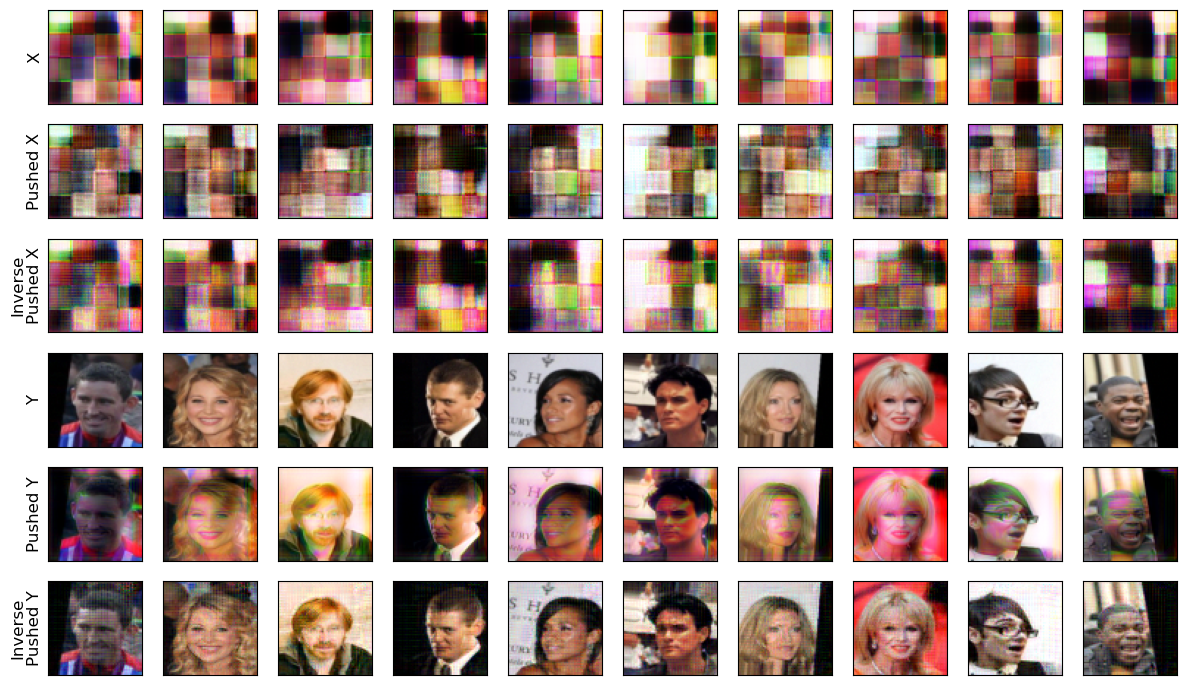

../src/distributions.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float32, requires_grad=False


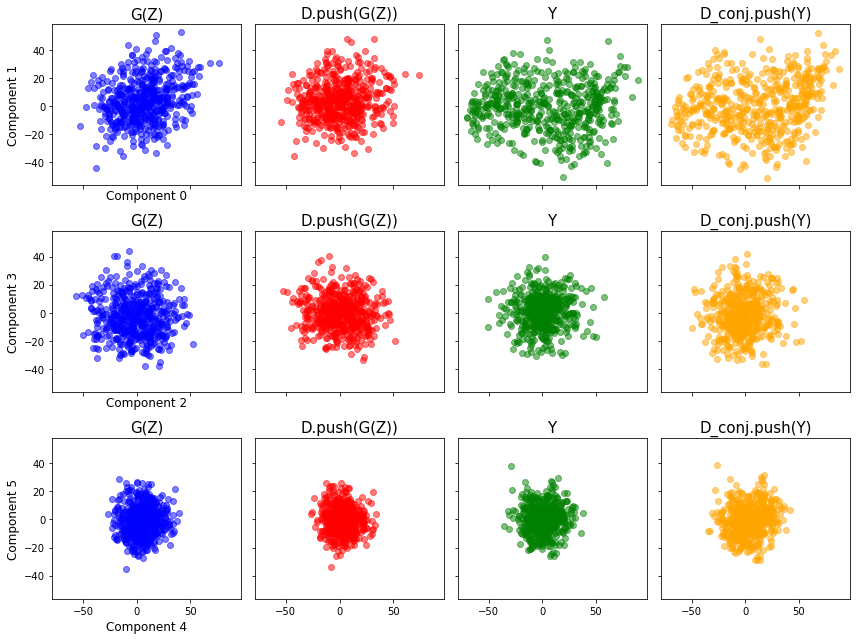

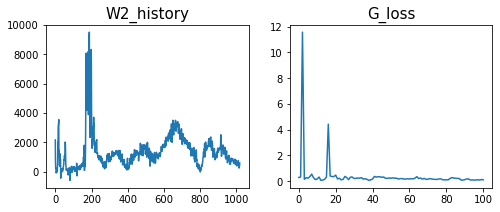

  0%|          | 102/300000 [50:44<2685:25:06, 32.24s/it]../src/distributions.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float32, requires_grad=False
  0%|          | 120/300000 [59:38<2474:21:47, 29.70s/it]

In [ ]:
for it in tqdm(range(MAX_ITER)):
    for iteration in range(D_ITERS):
        step += 1
    
        freeze(G)
        with torch.no_grad():
            X = G(Z_sampler.sample(BATCH_SIZE)).reshape(BATCH_SIZE, -1)
        X.requires_grad_(True)
        Y = Y_sampler.sample(BATCH_SIZE); Y.requires_grad_(True)

        if not REVERSED:
            unfreeze(D); freeze(D_conj)
            # Negative Wasserstein distance
            Y_inv = D_conj.push(Y).detach()
            D_opt.zero_grad()  
            W_loss = (D(X) - D(Y_inv)).mean()

            # Non-backpropagated part
            with torch.no_grad():
                W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
                ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()

            W2_history.append(-W_loss.item() - W_loss_nograd.item())
            W_loss.backward(); D_opt.step();

            unfreeze(D_conj); freeze(D)
            for inner_it in range(INNER_ITERS): 
                Y = Y_sampler.sample(BATCH_SIZE)
                Y.requires_grad_(True)

                D_conj_opt.zero_grad()
                Y_push = D_conj.push(Y)
                conj_loss = (D(Y_push) - (Y_push * Y).sum(dim=1, keepdims=True)).mean()
                conj_loss.backward()
                D_conj_opt.step(); 

        if REVERSED:
            unfreeze(D_conj); freeze(D)
            # Negative Wasserstein distance
            X_inv = D.push(X).detach()
            D_conj_opt.zero_grad()  
            W_loss = (D_conj(Y) - D_conj(X_inv)).mean()

            # Non-backpropagated part
            with torch.no_grad():
                W_loss_nograd = (- (Y ** 2).sum(dim=1) / 2).mean() +\
                ((X_inv * X).sum(dim=1) - (X_inv ** 2).sum(dim=1) / 2 ).mean()

            W2_history.append(-W_loss.item() - W_loss_nograd.item())
            W_loss.backward(); D_conj_opt.step();

            unfreeze(D); freeze(D_conj)
            for inner_it in range(INNER_ITERS): 
                with torch.no_grad():
                    X = G(Z_sampler.sample(BATCH_SIZE)).reshape(BATCH_SIZE, -1)
                X.requires_grad_(True)

                D_opt.zero_grad()
                X_push = D.push(X)
                conj_loss = (D_conj(X_push) - (X_push * X).sum(dim=1, keepdims=True)).mean()
                conj_loss.backward()
                D_opt.step();
    
    wandb.log({'W2' : W2_history[-1]}, step=step)
                
    if (it % PLOT_INTERVAL == 1):
        clear_output(wait=True)
        fig, axes = plot_generated_images(G, Z_sampler, Y_sampler, D, D_conj)
        wandb.log({'Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_generated_emb(Z_sampler, G, Y_sampler, D, D_conj, pca)
        wandb.log({'PCA' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig)   
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].set_title('W2_history', fontsize=15)
        axes[0].plot(W2_history[-5000:])
        axes[1].set_title('G_loss', fontsize=15)
        axes[1].plot(G_loss_history[-5000:])
        plt.show()
        plt.close(fig) 
        
    if (it % FID_INTERVAL == FID_INTERVAL - 1):
        print(" It is high time to compute FID score")
        m, s = get_generated_inception_stats(G, Z_sampler, size=200000, batch_size=8)
        FID_G = calculate_frechet_distance(m, s, mu_data, sigma_data)
        
        T_G = CompositeGenerator(G, D)
        m, s = get_generated_inception_stats(T_G, Z_sampler, size=200000, batch_size=8)
        FID_T_G = calculate_frechet_distance(m, s, mu_data, sigma_data)
        del m, s;  gc.collect(); torch.cuda.empty_cache()
                
        if min(FID_G, FID_T_G) < min_FID:
            min_FID = min(FID_G, FID_T_G)
            freeze(D); freeze(D_conj); freeze(G)
            torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'{METHOD}_D.pt'))
            torch.save(D_conj.state_dict(), os.path.join(OUTPUT_PATH, f'{METHOD}_D_conj.pt'))
            torch.save(G.state_dict(), os.path.join(OUTPUT_PATH, f'{METHOD}_G.pt'))
            
        wandb.log({'FID_G' : FID_G, 'FID_T_G' : FID_T_G}, step=step)
    
    freeze(D); freeze(D_conj); unfreeze(G)
    
    step += 1
    G_old = deepcopy(G); freeze(G_old)
    Z = Z_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        G_old_Z = G_old(Z).reshape(BATCH_SIZE, -1)
    G_old_Z.requires_grad_(True)
    
    # The gradient of this loss equals to the gradient of G(Z)^2/2 - D(G(Z))
    # This reformulation is used since in the reversed case D is unavailable, only D.push is given
    loss = F.mse_loss(G(Z).reshape(BATCH_SIZE, -1), D.push_nograd(G_old_Z))
    G_loss_history.append(loss.item())
    log = {"G_loss" : loss.item()}
    loss.backward()

    G_opt.step(); G_opt.zero_grad()
    wandb.log(log, step=step)